# Машинное обучение, ФКН ВШЭ

## Практическое задание 5. Решающие деревья

### Общая информация
Дата выдачи: 11.11.2021

Мягий дедлайн: 23:59MSK 23.11.2021

Жестокий дедлайн: 23:59MSK 26.11.2021

### О задании

Задание состоит из двух разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы попробуете реализовать свое решающее дерево и сравните его со стандартное имплиментацией из sklearn. Вы также протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-05-trees-Username.ipynb
* Модуль hw5code.py
* Ссылки на посылки в Яндекс.Контесте для обеих задач

В контест https://contest.yandex.ru/contest/31332/problems/ нужно отправить файл hw5code.py с реализованными функциями и классами.

Username — ваша фамилия и имя на латинице именно в таком порядке

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже:

__Оценка:__

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='whitegrid')
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [2]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=0),
    make_moons(noise=0.2, random_state=0),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=0, 
                        n_redundant=0., )
]

In [3]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

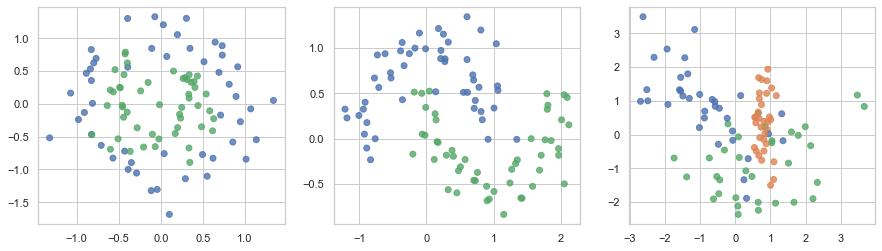

In [4]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__Задание 1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [5]:
def plot_surface(clf, X, y):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)

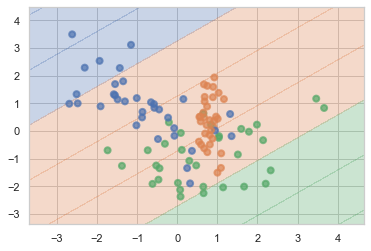

In [6]:
# Пример:
from sklearn.linear_model import LinearRegression
X, y = datasets[2]
lr  = LinearRegression().fit(X, y)
plot_surface(lr, X, y)

In [7]:
names = ('circles', 'moons', 'classification')

full_dataset = {i: {} for i in names}
for i, j in enumerate(names):
    X_train, X_test, y_train, y_test = train_test_split(datasets[i][0], datasets[i][1], test_size=0.4, random_state=0)
    for k, q in zip((datasets[i], X_train, X_test, y_train, y_test), ('dataset', 'X_train', 'X_test', 'y_train', 'y_test')):
        full_dataset[j][q] = k

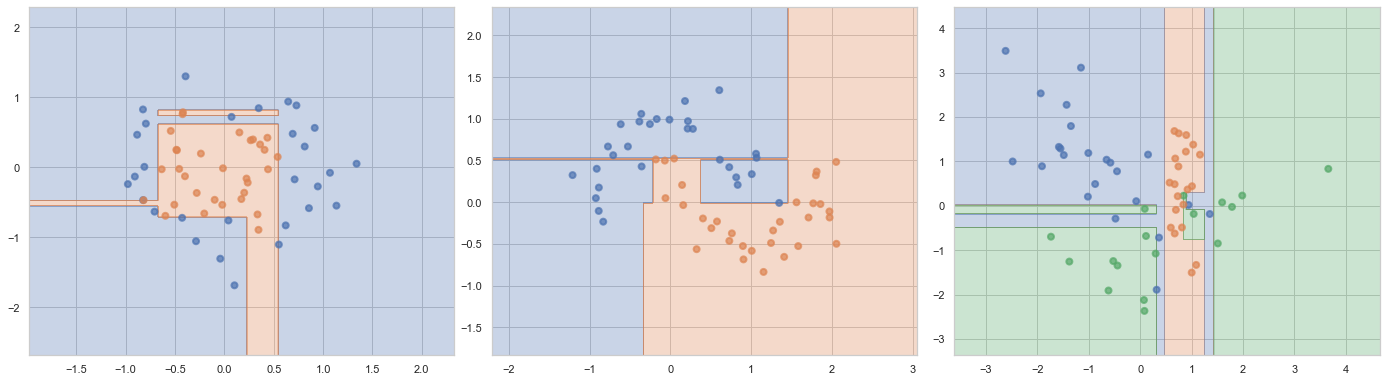

In [8]:
models = {}

plt.figure(figsize=(20, 6))
for i, name in enumerate(names):
    clf = DecisionTreeClassifier()
    clf.fit(full_dataset[name]['X_train'], full_dataset[name]['y_train'])
    models[name] = clf

    plt.subplot2grid((1, 3), (0, i))
    plot_surface(clf, full_dataset[name]['X_train'], full_dataset[name]['y_train'])    

In [9]:
for i in names:
    print('Accuracy score for {0} is {1}'.format(i, accuracy_score(full_dataset[i]['y_test'], models[i].predict(full_dataset[i]['X_test']))))

Accuracy score for circles is 0.775
Accuracy score for moons is 0.975
Accuracy score for classification is 0.725


__Ответ:__ Кажется, что деревья не очень сильно переобучились, так как accuracy scores достаточно высокие.

__Задание 2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?

Вывод accuracy для moons:

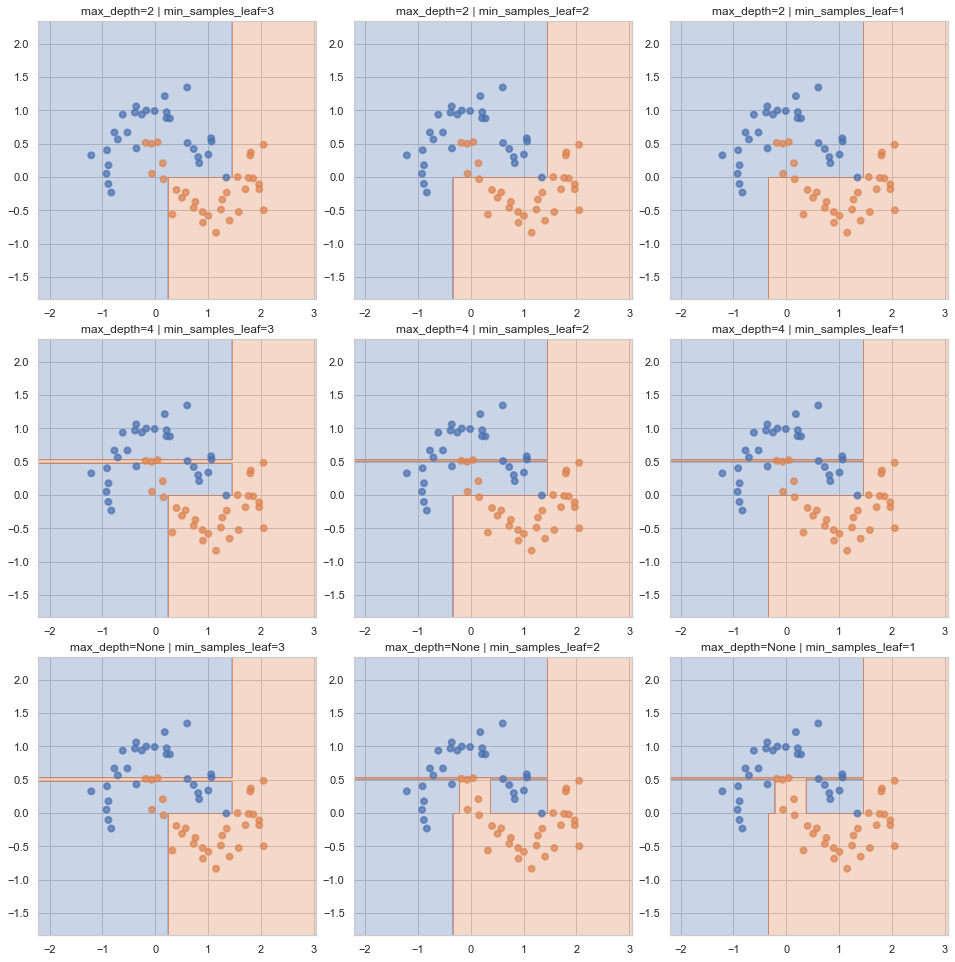

In [10]:
plt.figure(figsize=(14, 14))
for i, max_depth in enumerate([2, 4, None]):
    for j, min_samples_leaf in enumerate([3, 2, 1]):
        clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
        clf.fit(full_dataset['moons']['X_train'], full_dataset['moons']['y_train'])
      
        plt.subplot2grid((3, 3), (i, j))
        plot_surface(clf, full_dataset['moons']['X_train'], full_dataset['moons']['y_train'])  
        plt.title('max_depth=' + str(max_depth) + ' | min_samples_leaf=' + str(min_samples_leaf))

In [11]:
for i, max_depth in enumerate([2, 4, None]):
    for j, min_samples_leaf in enumerate([3, 2, 1]):
        clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
        clf.fit(full_dataset['moons']['X_train'], full_dataset['moons']['y_train'])
        train_a = accuracy_score(full_dataset['moons']['y_train'], clf.predict(full_dataset['moons']['X_train']))
        test_a = accuracy_score(full_dataset['moons']['y_test'], clf.predict(full_dataset['moons']['X_test']))
        print('Accuracy for train set is {0} and for test set is {1} with parameters max_depth = {2} and min_samples_leaf = {3}'.format(train_a, test_a, max_depth, min_samples_leaf))

Accuracy for train set is 0.9 and for test set is 0.85 with parameters max_depth = 2 and min_samples_leaf = 3
Accuracy for train set is 0.9166666666666666 and for test set is 0.925 with parameters max_depth = 2 and min_samples_leaf = 2
Accuracy for train set is 0.9166666666666666 and for test set is 0.925 with parameters max_depth = 2 and min_samples_leaf = 1
Accuracy for train set is 0.9333333333333333 and for test set is 0.8 with parameters max_depth = 4 and min_samples_leaf = 3
Accuracy for train set is 0.95 and for test set is 0.9 with parameters max_depth = 4 and min_samples_leaf = 2
Accuracy for train set is 0.95 and for test set is 0.9 with parameters max_depth = 4 and min_samples_leaf = 1
Accuracy for train set is 0.9333333333333333 and for test set is 0.8 with parameters max_depth = None and min_samples_leaf = 3
Accuracy for train set is 1.0 and for test set is 0.975 with parameters max_depth = None and min_samples_leaf = 2
Accuracy for train set is 1.0 and for test set is 0.9

Вывод accuracy для circles:

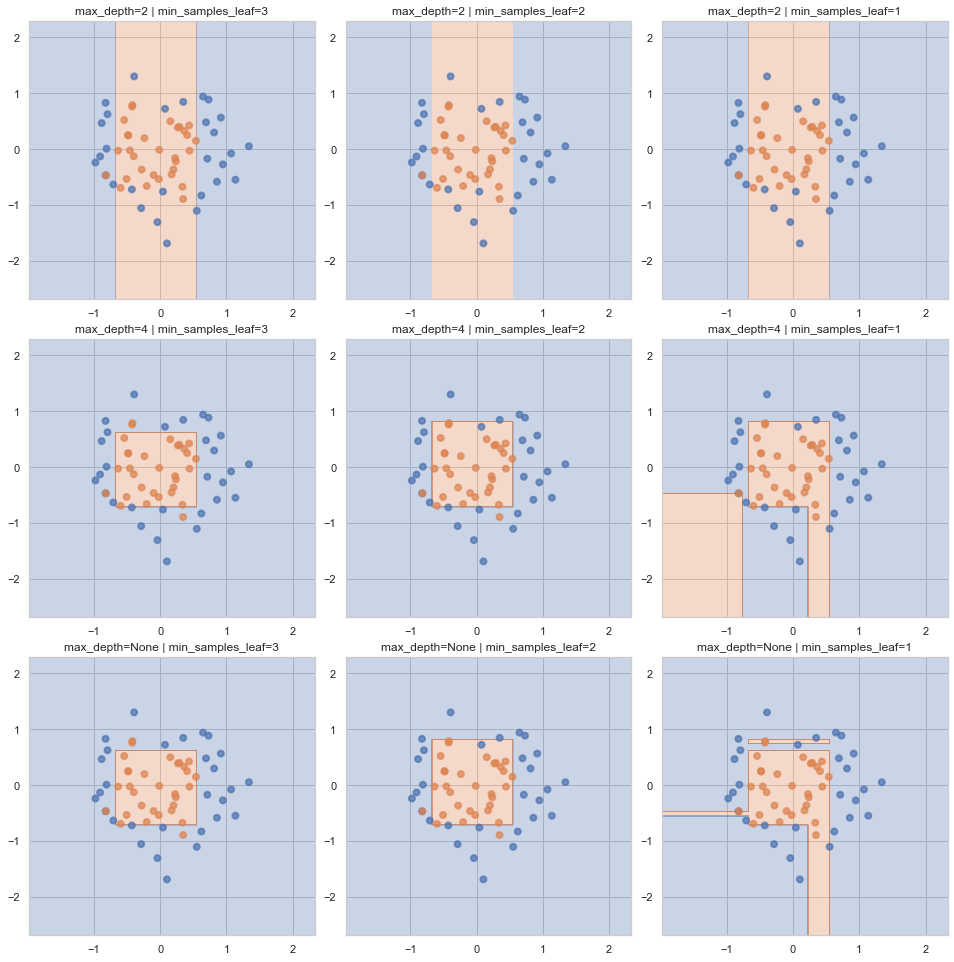

In [12]:
plt.figure(figsize=(14, 14))
for i, max_depth in enumerate([2, 4, None]):
    for j, min_samples_leaf in enumerate([3, 2, 1]):
        clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
        clf.fit(full_dataset['circles']['X_train'], full_dataset['circles']['y_train'])
      
        plt.subplot2grid((3, 3), (i, j))
        plot_surface(clf, full_dataset['circles']['X_train'], full_dataset['circles']['y_train'])  
        plt.title('max_depth=' + str(max_depth) + ' | min_samples_leaf=' + str(min_samples_leaf))

In [13]:
for i, max_depth in enumerate([2, 4, None]):
    for j, min_samples_leaf in enumerate([3, 2, 1]):
        clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
        clf.fit(full_dataset['circles']['X_train'], full_dataset['circles']['y_train'])
        train_a = accuracy_score(full_dataset['circles']['y_train'], clf.predict(full_dataset['circles']['X_train']))
        test_a = accuracy_score(full_dataset['circles']['y_test'], clf.predict(full_dataset['circles']['X_test']))
        print('Accuracy for train set is {0} and for test set is {1} with parameters max_depth = {2} and min_samples_leaf = {3}'.format(train_a, test_a, max_depth, min_samples_leaf))

Accuracy for train set is 0.85 and for test set is 0.6 with parameters max_depth = 2 and min_samples_leaf = 3
Accuracy for train set is 0.85 and for test set is 0.6 with parameters max_depth = 2 and min_samples_leaf = 2
Accuracy for train set is 0.85 and for test set is 0.6 with parameters max_depth = 2 and min_samples_leaf = 1
Accuracy for train set is 0.9333333333333333 and for test set is 0.85 with parameters max_depth = 4 and min_samples_leaf = 3
Accuracy for train set is 0.95 and for test set is 0.85 with parameters max_depth = 4 and min_samples_leaf = 2
Accuracy for train set is 0.9833333333333333 and for test set is 0.775 with parameters max_depth = 4 and min_samples_leaf = 1
Accuracy for train set is 0.9333333333333333 and for test set is 0.85 with parameters max_depth = None and min_samples_leaf = 3
Accuracy for train set is 0.95 and for test set is 0.85 with parameters max_depth = None and min_samples_leaf = 2
Accuracy for train set is 1.0 and for test set is 0.8 with paramet

__Ответ:__ Очевидно.

# 2. Решающие деревья своими руками

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__Задание 3. (1.5 балл)__

Реализуйте функцию find_best_split из модуля hw5code.py

DONE

__Задание 4. (0.5 балла)__

Загрузите таблицу [students.csv](https://github.com/esokolov/ml-course-hse/blob/master/2021-fall/homeworks-practice/homework-practice-05-trees/students.csv) (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hw5code as tree

In [24]:
data = pd.read_csv('students.csv')

data.head(5)

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,1
4,0.08,0.08,0.08,0.98,0.24,0


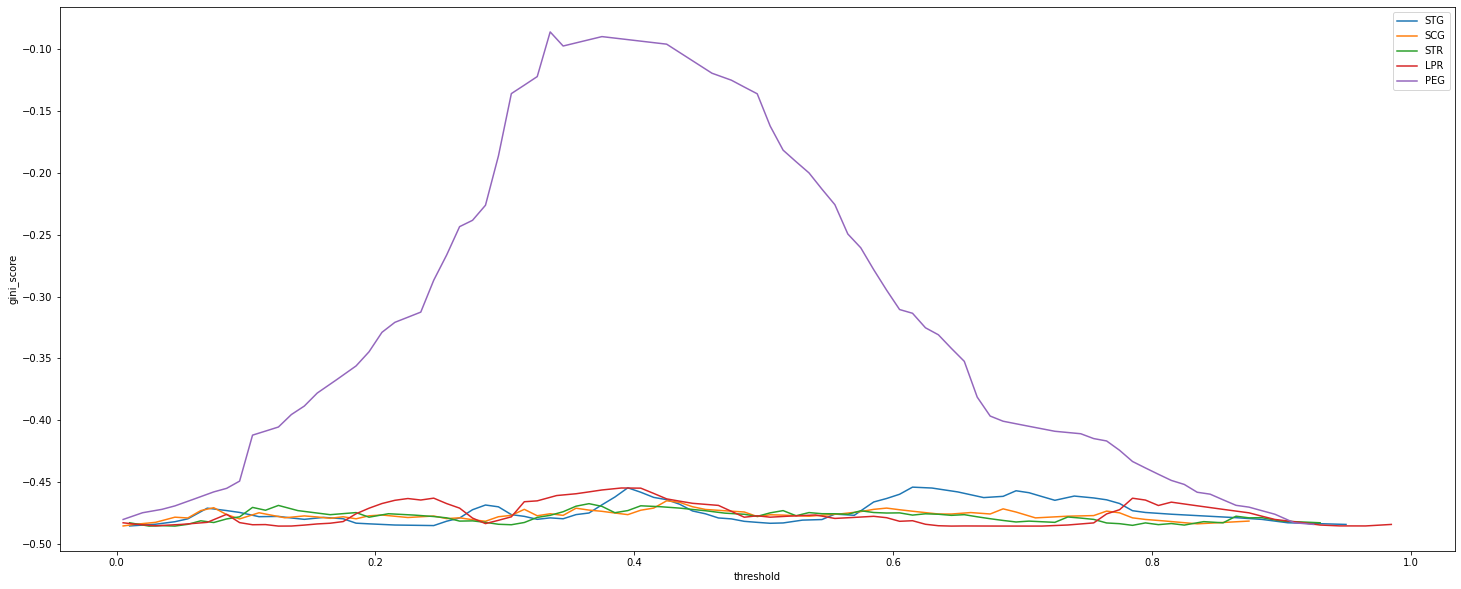

In [48]:
features = ['STG', 'SCG', 'STR', 'LPR', 'PEG']

plt.figure(figsize=(25, 10))

for feature in features:
    threshold, ginis, _, _ = tree.find_best_split(np.array(data[feature]), np.array(data.UNS))
    plt.plot(threshold, ginis, label=feature)

plt.xlabel('threshold')
plt.ylabel("gini_score")
plt.legend()
plt.show()

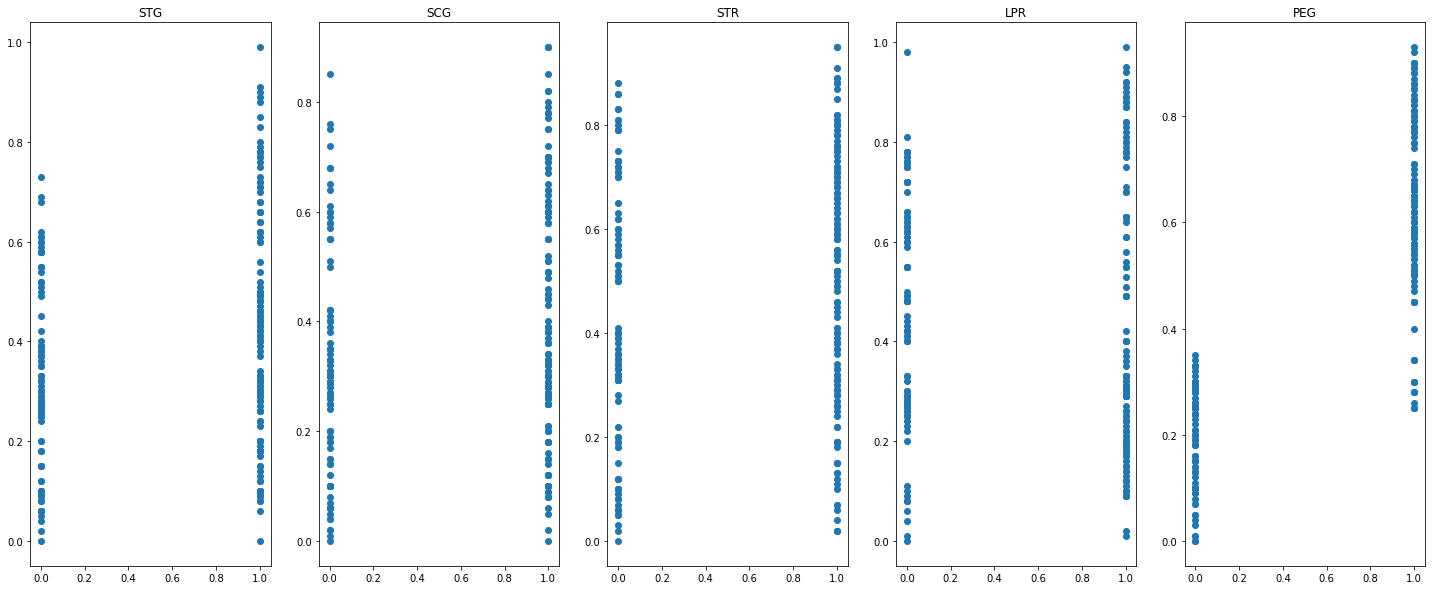

In [40]:
plt.figure(figsize=(25, 10))

for feature, i in zip(features, range(5)):
    plt.subplot2grid((1, 5), (0, i))
    plt.scatter(data.UNS, data[feature])
    plt.title(feature)

__Задание 5. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:** На фоне всех признаков сильно выделяется признак PEG, так как оптимальное разбиение по этому признаку дает высокое значение критерия Джини. Данный результат согласуется с построенными scatter-графиками. На графике для признака PEG отчетливо видно, что данные хорошо деляется на две группы по данному признаку. Графики для остальных признаков отображают, что критерий Джини по сути не зависит от порога, а значит распредленны равномерно по обоим классам. 

__Задание 6. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw5code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в [лекции](https://github.com/esokolov/ml-course-hse/blob/master/2020-fall/lecture-notes/lecture07-trees.pdf) в разделе «Построение дерева». Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

DONE

__Задание 7. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [40]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from hw5code import DecisionTree
from sklearn.metrics import accuracy_score

mushrooms = pd.read_csv('agaricus-lepiota.data')

for i in mushrooms.columns:
    mushrooms[i] = LabelEncoder().fit_transform(mushrooms[i])

y = np.array(mushrooms['p'])
X = np.array(mushrooms.drop(columns=['p']))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

In [41]:
model = DecisionTree(['categorical' for i in range(22)])

model.fit(X_train, y_train)
accuracy_score(y_test, model.predict(X_test))

1.0

__Задание 8. (бонус, 1 балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

In [46]:
tic_tac_toe = pd.read_csv('tic-tac-toe.data')

for i in tic_tac_toe.columns:
    tic_tac_toe[i] = LabelEncoder().fit_transform(tic_tac_toe[i])

y = np.array(tic_tac_toe['positive'])
X = np.array(tic_tac_toe.drop(columns=['positive']))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

In [58]:
for i in [2, 3, 4, 5, 6, 7, 8]:
     model = DecisionTree(['categorical' for i in range(9)], max_depth=i)

     model.fit(X_train, y_train)
     print('accuracy for max_depth = {0} is {1}'.format(i, accuracy_score(y_train, model.predict(X_train))))

accuracy for max_depth = 2 is 0.698744769874477
accuracy for max_depth = 3 is 0.7426778242677824
accuracy for max_depth = 4 is 0.8326359832635983
accuracy for max_depth = 5 is 0.9016736401673641
accuracy for max_depth = 6 is 0.9456066945606695
accuracy for max_depth = 7 is 0.9790794979079498
accuracy for max_depth = 8 is 0.9916317991631799


In [62]:
for i in [10, 20, 30, 40, 50, 60]:
     model = DecisionTree(['categorical' for i in range(9)], min_samples_split=i)

     model.fit(X_train, y_train)
     print('accuracy for min_samples_split = {0} is {1}'.format(i, accuracy_score(y_train, model.predict(X_train))))

accuracy for min_samples_split = 10 is 0.9497907949790795
accuracy for min_samples_split = 20 is 0.9142259414225942
accuracy for min_samples_split = 30 is 0.8870292887029289
accuracy for min_samples_split = 40 is 0.8263598326359832
accuracy for min_samples_split = 50 is 0.7907949790794979
accuracy for min_samples_split = 60 is 0.7824267782426778


In [64]:
for i in [10, 20, 30, 40, 50, 60]:
     model = DecisionTree(['categorical' for i in range(9)], min_samples_leaf=i)

     model.fit(X_train, y_train)
     print('accuracy for min_samples_leaf = {0} is {1}'.format(i, accuracy_score(y_train, model.predict(X_train))))

accuracy for min_samples_leaf = 10 is 0.8870292887029289
accuracy for min_samples_leaf = 20 is 0.799163179916318
accuracy for min_samples_leaf = 30 is 0.7824267782426778
accuracy for min_samples_leaf = 40 is 0.7384937238493724
accuracy for min_samples_leaf = 50 is 0.698744769874477
accuracy for min_samples_leaf = 60 is 0.698744769874477
